mask segmentation은 OK. 근데 mask와 class가 같이 있는 것은 아니다. 어떻게 classification 할 것인가? 
1. mask img에 class 별 색깔 부여
2. masking에서 한번 output 뽑고, classifer에 한번 더 학습?

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D, Dense, UpSampling2D, Flatten, Reshape,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2

2025-11-20 15:34:40.114437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 15:34:40.121440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763620480.130084  536453 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763620480.132775  536453 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763620480.139478  536453 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
print("TensorFlow Version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.1
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#trying our basic unet for segmentation

import glob
from sklearn.model_selection import train_test_split

img_width=224  #128
img_height=224  #128
img_channels=3

# changed
base_path='/home/JGY/mri_cnn/data/segmentation_Dataset/brisc2025/segmentation_task'

train_image_path= os.path.join(base_path,'train/images')
train_mask_path= os.path.join(base_path,'train/masks')
test_image_path= os.path.join(base_path,'test/images')
test_mask_path= os.path.join(base_path,'test/masks')

def load_preprocess(image_dir, mask_dir):
  image_files=sorted(glob.glob(os.path.join(image_dir, '*.*')))
  mask_files=sorted(glob.glob(os.path.join(mask_dir, '*.*')))
  if len(image_files) != len(mask_files):
    print(f"Error: Mismatch in file counts")
    print(f"Images found: {len(image_files)}, masks found = {len(image_files)}")
    return None, None
  X= []
  Y=[]
  print(f"Loading{len(image_files)}images and masks..")

  for img_path, mask_path in zip(image_files, mask_files):
    try:
      img=cv2.imread(img_path, cv2.IMREAD_COLOR)
      img=cv2.resize(img, (img_width, img_height))
      img=img/255.0
      mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask=cv2.resize(mask,(img_width, img_height))
      mask=(mask>128).astype(np.float32)
      X.append(img)
      Y.append(mask)
    except Exception as e:
     print(f"Error loading image or mask: {e}")

  X=np.array(X)
  Y=np.array(Y)
  Y=np.expand_dims(Y, axis=-1)

  return X, Y

X_train, y_train= load_preprocess(train_image_path, train_mask_path)
# X_train과 y_train을 80-20 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  #, stratify=y_train
)

X_test, y_test= load_preprocess(test_image_path, test_mask_path)
print(f"\nData loading complete.")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Loading3933images and masks..
Loading860images and masks..

Data loading complete.
X_train shape: (3146, 224, 224, 3)
y_train shape: (3146, 224, 224, 1)
X_val shape:   (787, 224, 224, 3)
y_val shape:   (787, 224, 224, 1)
X_test shape:  (860, 224, 224, 3)
y_test shape:  (860, 224, 224, 1)


In [5]:
X_trains = X_train / np.max(X_train)
#y_train..?
X_tests = X_test / np.max(X_train)
X_vals = X_val/np.max(X_train)
print('X_tests[0] min_Max:',X_tests[0].min(), X_tests[0].max())
print('y_tests[0] min_Max:',y_test[0].min(), y_test[0].max())  #검정/흰색

X_tests[0] min_Max: 0.0 0.9607843137254902
y_tests[0] min_Max: 0.0 1.0


In [6]:
#train autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 입력 정의 (예: 80x80x3 이미지)
input_img = Input(shape=(224, 224, 3))

# --- Encoder ---
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization(name='encoded_output')(encoded)
#encoded =  MaxPooling2D((2, 2))(encoded)  #뭔가 이상

# --- Decoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)#
x = BatchNormalization()(x)#
x = UpSampling2D((2, 2))(x)
x = Dropout(0.1)(x)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(decoded)  #이상해서 수정



autoencoder_aug = Model(input_img, decoded)
autoencoder_aug.compile(optimizer='adam', loss='mse')
autoencoder_aug.summary()

datagen = ImageDataGenerator(
    rotation_range=15,           # 0~90도 사이 랜덤 회전
    horizontal_flip=True,        # 좌우반전 허용
    vertical_flip=False,      # 상하반전 허용
    zoom_range=0.2           
)

autoencoder_train_generator = datagen.flow(
    X_trains, y_train,  
    batch_size=16
)


def simple_gen():
    for data, labels in autoencoder_train_generator:
        labels[:] = data
        yield data, labels

# 3. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('segmentation_autoencoder.keras', monitor='test_loss', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 어떤 지표를 관찰할지 지정합니다 (일반적으로 검증 손실 'val_loss')
    factor=0.2,  # 학습률을 얼마나 감소시킬지 지정합니다 (새로운 LR = 기존 LR * factor)
    patience=10, # 이 지표가 몇 epoch 동안 개선되지 않을 때 학습률을 감소시킬지 지정합니다
    verbose=1, # 업데이트 메시지를 표시합니다
    mode='min',# 관찰 지표가 감소해야 개선으로 간주합니다 ('val_loss'의 경우 'min')
    min_lr=0.000001  # 학습률의 최소 하한선을 지정합니다
)

I0000 00:00:1763620496.104256  536453 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_output                  │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 1,115,873 (4.26 MB)

 Trainable params: 1,113,377 (4.25 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [18]:
# Autoencoder 학습 시 generator 사용 예 (input = output)
autoencoder_aug.fit(
    #simple_gen(),
    X_trains, y_train, 
    epochs=80,
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_vals,y_val),
    callbacks=[early_stopping, model_checkpoint,reduce_lr]
)

Epoch 1/80


2025-11-20 11:50:25.001357: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-20 11:50:29.499465: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


186/196 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.0364

/home/JGY/anaconda3/envs/mri_2025_11/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: saving model to segmentation_autoencoder.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - loss: 0.0201 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 2/80
185/196 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0159
Epoch 2: saving model to segmentation_autoencoder.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - loss: 0.0161 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 3/80
185/196 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0163
Epoch 3: saving model to segmentation_autoencoder.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 0.0164 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 4/80
185/196 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0162
Epoch 4: saving model to segmentation_autoencoder.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - loss: 0.0164 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 5/80
185/196 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0161
Epoch 5: saving model to segmentation_autoencoder.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 14

/home/JGY/anaconda3/envs/mri_2025_11/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 122 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1763620500.536453  537388 service.cc:152] XLA service 0x7d6908029be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763620500.536470  537388 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-11-20 15:35:00.547686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763620500.626622  537388 cuda_dnn.cc:529] Loaded cuDNN version 90101


 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

I0000 00:00:1763620505.761874  537388 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step


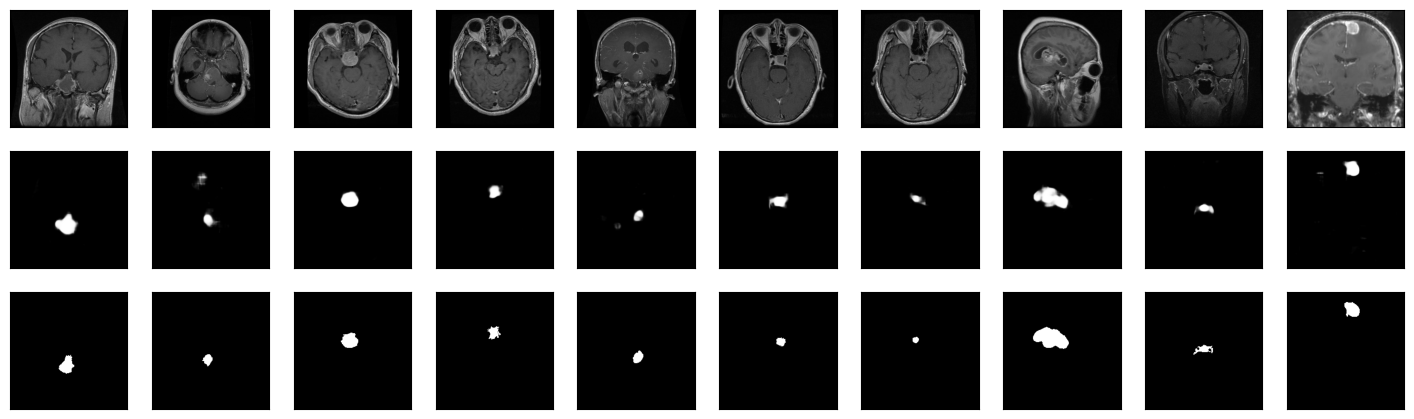

In [7]:
#check performance of autoencoder
autoencoder_aug.load_weights('segmentation_autoencoder.keras')
#decoded_val_images = autoencoder_aug.predict(X_vals)
decoded_test_images = autoencoder_aug.predict(X_tests)

n_images = 10
test_images = np.random.randint(0, X_tests.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # input images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_tests[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded val
  ax = plt.subplot(10,10, i + 1 + n_images )
  plt.imshow(decoded_test_images[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
   # Decoded val
  ax = plt.subplot(10,10, i + 1 + 2*n_images )
  plt.imshow(y_test[image_index],cmap='gray')
  plt.xticks(())
  plt.yticks(())
  

In [8]:
# --- Prediction and Visualization ---
output_dir = 'segmentation'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

autoencoder_aug.load_weights('segmentation_autoencoder.keras')
decoded_test_images = autoencoder_aug.predict(X_tests)

num_test_images = X_tests.shape[0]
images_per_plot = 10

for i in range(0, num_test_images, images_per_plot):
    plt.figure(figsize=(18, 6))
    
    for j in range(images_per_plot):
        if i + j < num_test_images:
            image_index = i + j
            
            # Original Image
            ax = plt.subplot(3, images_per_plot, j + 1)
            plt.imshow(X_tests[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Original', fontsize=10)

            # Decoded Image
            ax = plt.subplot(3, images_per_plot, j + 1 + images_per_plot)
            plt.imshow(decoded_test_images[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Decoded', fontsize=10)

            # Ground Truth Mask
            ax = plt.subplot(3, images_per_plot, j + 1 + 2 * images_per_plot)
            plt.imshow(y_test[image_index], cmap='gray')
            plt.xticks(())
            plt.yticks(())
            if j == 0:
                plt.ylabel('Ground Truth', fontsize=10)

    plt.suptitle(f'Images {i} to {i + images_per_plot - 1}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    output_path = os.path.join(output_dir, f'segmentation_results_{i // images_per_plot}.png')
    plt.savefig(output_path)
    plt.close()
    print(f"Saved plot to {output_path}")

print("Processing complete.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Saved plot to segmentation/segmentation_results_0.png
Saved plot to segmentation/segmentation_results_1.png
Saved plot to segmentation/segmentation_results_2.png
Saved plot to segmentation/segmentation_results_3.png
Saved plot to segmentation/segmentation_results_4.png
Saved plot to segmentation/segmentation_results_5.png
Saved plot to segmentation/segmentation_results_6.png
Saved plot to segmentation/segmentation_results_7.png
Saved plot to segmentation/segmentation_results_8.png
Saved plot to segmentation/segmentation_results_9.png
Saved plot to segmentation/segmentation_results_10.png
Saved plot to segmentation/segmentation_results_11.png
Saved plot to segmentation/segmentation_results_12.png
Saved plot to segmentation/segmentation_results_13.png
Saved plot to segmentation/segmentation_results_14.png
Saved plot to segmentation/segmentation_results_15.png
Saved plot to segmentation/segmentation_results_16.png
Saved plot to segmentation/segmenta